In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torch.nn.functional as F
import torch.optim as optim
from torchtext.vocab import Vocab
import random
import numpy as np

In [ ]:
#### STEP 1: Import the data
drive.mount('/content/drive/')
data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2023/Final/Results/'

data = pd.read_csv(data_path+'Yelp.csv')

Mounted at /content/drive/


<ipython-input-2-2ac0fe2f227a>:6: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path+'Yelp.csv')


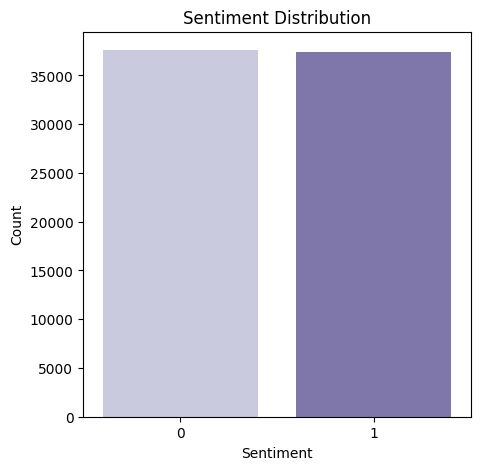

In [ ]:
#### STEP 2: See how many reviews we have of each sentiment
data.sentiment.replace(1, 0, inplace=True)
data.sentiment.replace(2, 1, inplace=True)

# Calculate the count of each sentiment
dist = data.groupby("sentiment").size()

# Create the bar plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x=dist.index, y=dist.values, ax=ax, palette = 'Purples')

# Customize the plot
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")
ax.set_title("Sentiment Distribution")

# Display the plot
plt.show()

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def normalize_text(text):
  # Set all characters to lowercase
  text = text.lower()
  # Remove HTML tags
  text = re.sub('<br />', '', text)
  # Remove URLs
  text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
  # Remove all punctuation marks
  text = re.sub(r'[^a-zA-Z0-9\s@#]', '', text)
  # Break text into individual linguistic units
  text_tokens = word_tokenize(text)
  # Remove common words that are considered to be insignificant and reduce words to their base or root form
  filtered_text = [PorterStemmer().stem(w) for w in text_tokens if w not in stop_words]
  return " ".join(filtered_text)

#### STEP 3: Normalize the reviews
data.review = data.review.apply(normalize_text)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

# Extract reviews and sentiments from the DataFrame
reviews = data['review'].values
sentiments = data['sentiment'].values

# Hyperparameters
vocab_size = 25000
max_length = 10  # Maximum length of each review sequence
embedding_dim = 100  # Dimensionality of word embeddings

# Tokenize the reviews
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Pad sequences to ensure equal length
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# #### STEP 4: Split into train and test
total_train = int(len(padded_sequences) * 0.75)
total_test = int(len(padded_sequences) * 0.25)

train_data_review = padded_sequences[:total_train]
test_data_review = padded_sequences[total_train:]

train_data_sentiment = sentiments[:total_train]
test_data_sentiment = sentiments[total_train:]

In [ ]:
#### STEP 6: Convert the data to tensors
train_r_tensor = torch.FloatTensor(train_data_review)
train_s_tensor = torch.FloatTensor(train_data_sentiment)

test_r_tensor = torch.FloatTensor(train_data_review)
test_s_tensor = torch.FloatTensor(train_data_sentiment)

# Create PyTorch datasets
train_dataset = TensorDataset(train_r_tensor, train_s_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#print(train_r_tensor)

In [ ]:
# Training loop
def train(train_loader, criterion, optimizer, model, num_epochs):
  list_loss = []
  total_step = len(train_loader)
  for epoch in range(num_epochs):
    temp = []
    for i, (inputs, labels) in enumerate(train_loader):
        # Forward pass
        inputs = inputs.long()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        temp.append(loss.item())
    if epoch == 0:
      print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, temp[0])) # Print the initial loss
    l = min(temp)
    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, l)) # Print the loss in each epoch
    list_loss.append(l)
  return list_loss

def test(model, test_data, test_labels):
    model.eval()
    with torch.no_grad():
        outputs = model(test_data.long())
        predicted = (outputs > 0.5).float()
        accuracy = (predicted == test_labels.unsqueeze(1)).sum().item() / len(test_labels)
        print('Test Accuracy of the model: {} %'.format(accuracy * 100))

Epoch [0/20], Loss: 0.6943
Epoch [1/20], Loss: 0.2098
Epoch [2/20], Loss: 0.1289
Epoch [3/20], Loss: 0.0848
Epoch [4/20], Loss: 0.0861
Epoch [5/20], Loss: 0.0561
Epoch [6/20], Loss: 0.0717
Epoch [7/20], Loss: 0.0461
Epoch [8/20], Loss: 0.0293
Epoch [9/20], Loss: 0.0651
Epoch [10/20], Loss: 0.0461
Epoch [11/20], Loss: 0.0504
Epoch [12/20], Loss: 0.0481
Epoch [13/20], Loss: 0.0452
Epoch [14/20], Loss: 0.0528
Epoch [15/20], Loss: 0.0354
Epoch [16/20], Loss: 0.0341
Epoch [17/20], Loss: 0.0413
Epoch [18/20], Loss: 0.0428
Epoch [19/20], Loss: 0.0491
Epoch [20/20], Loss: 0.0282


Text(0, 0.5, 'Loss Val')

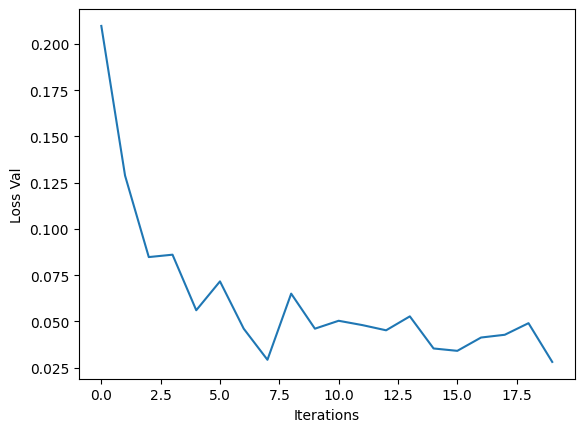

In [ ]:
#### STEP 7: Prepare the deep learning model
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)#.float()
        output, _ = self.lstm(embedded)
        output = output[:, -1, :]  # Take the last output of the LSTM sequence
        x = torch.relu(self.fc1(output))
        x = self.sigmoid(self.fc2(x))
        return x

#### STEP 8: # Instantiate the models
embedding_dim = 100
hidden_size = 64
num_layers = 2

#model = SentimentModel(vocab_size, embedding_dim, input_dim, hidden_size, num_layers)
model = SentimentModel(vocab_size, embedding_dim, hidden_size, num_layers)
oov_token='<OOV>'
# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

#### STEP 9: Train the model
list_loss = train(train_loader, criterion, optimizer, model, num_epochs = 20)
plt.plot(list_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss Val')

In [ ]:
#### Step 10: Evaluate the model
accuracy = test(model, test_r_tensor, test_s_tensor)

Test Accuracy of the model: 90.61333333333333 %


In [ ]:
#### Step 11: Test our model with a new user input
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
   model.eval()
   # Text normalization and tokenization
   text = normalize_text(sentence)
   sequence = tokenizer.texts_to_sequences([text])
   padded_sequence = pad_sequences(sequence, maxlen=max_length)
   r_tensor = torch.LongTensor(padded_sequence)
   # Perform the prediction
   with torch.no_grad():
       prediction = model(r_tensor)
   # Determine the sentiment based on the prediction
   if prediction.item() > 0.5:
       sentiment = 'Positive'
   else:
       sentiment = 'Negative'
   return sentiment, prediction.item()


review = "Horrible, terrible, don't go there."
result, score = predict_sentiment(model, review)
print("Review:", review)
print(f"Predicted Sentiment: {result}, {score}")
print("\n")
review = "Amazing, I love this place!"
result, score = predict_sentiment(model, review)
print("Review:", review)
print(f"Predicted Sentiment: {result}, {score}")

Review: Horrible, terrible, don't go there.
Predicted Sentiment: Negative, 0.00557315070182085


Review: Amazing, I love this place!
Predicted Sentiment: Positive, 0.9986950755119324
